In [1]:
# Light GBM for Avito Demand Prediction Challenge
# Uses Bag-of-Words, meta-text features, and dense features.

import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Gradient Boosting
import lightgbm as lgb

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
training = pd.read_csv('train.csv', index_col = "item_id", parse_dates = ["activation_date"])
traindex = training.index
testing = pd.read_csv('test.csv', index_col = "item_id", parse_dates = ["activation_date"])
testdex = testing.index
y = training.deal_probability.copy().clip(0.0, 1.0)
training.drop("deal_probability",axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

Train shape: 1503424 Rows, 16 Columns
Test shape: 508438 Rows, 16 Columns


In [3]:
print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Combine Train and Test

All Data shape: 2011862 Rows, 16 Columns


In [4]:
print("Feature Engineering")
df["price"] = np.log(df["price"]+0.001)
df["price"].fillna(-999,inplace=True)
df["image_top_1"].fillna(-999,inplace=True)

print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday
df["Weekd of Year"] = df['activation_date'].dt.week
df["Day of Month"] = df['activation_date'].dt.day

Feature Engineering

Create Time Variables


In [5]:
# Create Validation Index and Remove Dead Variables
training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index
df.drop(["activation_date","image"],axis=1,inplace=True)

In [6]:
print("\nEncode Variables")
categorical = ["user_id","region","city","parent_category_name","category_name","item_seq_number","user_type","image_top_1"]
print("Encoding :",categorical)

# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col] = lbl.fit_transform(df[col].astype(str))


Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'item_seq_number', 'user_type', 'image_top_1']


In [7]:
print("\nText Features")

# Feature Engineering 
df['text_feat'] = df.apply(lambda row: ' '.join([
    str(row['param_1']), 
    str(row['param_2']), 
    str(row['param_3'])]),axis=1) # Group Param Features
df.drop(["param_1","param_2","param_3"],axis=1,inplace=True)


Text Features


In [8]:
# Meta Text Features
textfeats = ["description","text_feat", "title"]

for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('nicapotato') # FILL NA
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_chars'] = df[cols].apply(len) # Count number of Characters
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words


In [9]:
print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))
print(len(russian_stop))


[TF-IDF] Term Frequency Inverse Document Frequency Stage
151


In [10]:
tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}

In [11]:
def get_col(col_name): return lambda x: x[col_name]

vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=15000,
            preprocessor=get_col('description'),
            **tfidf_para)),
        ('text_feat',CountVectorizer(
            ngram_range=(1, 2),
            max_features=7000,
            preprocessor=get_col('text_feat'))),
        ('title',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=7000,
            preprocessor=get_col('title'),
            **tfidf_para))
    ])


In [12]:
start_vect=time.time()
vectorizer.fit(df.loc[traindex,:].to_dict('records'))
ready_df = vectorizer.transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

Vectorization Runtime: 27.04 Minutes


In [13]:
#len(tfvocab)
np.save('ready_df.npy',np.asarray(ready_df))

In [14]:
np.save('tfvocab.npy',np.asarray(tfvocab))

In [ ]:
tfvocab[20000]
ready_df.shape

In [ ]:
# ready_df = np.fromfile('ready_df.npy', dtype='uint8') #np.load('ready_df.npy')
# tfvocab = np.load('tfvocab.npy')

In [15]:
df.drop(textfeats, axis=1,inplace=True)

In [ ]:
# Drop Text Cols
df.drop(textfeats, axis=1,inplace=True)

# Dense Features Correlation Matrix
f, ax = plt.subplots(figsize=[10,7])
sns.heatmap(pd.concat([df.loc[traindex,[x for x in df.columns if x not in categorical]], y], axis=1).corr(),
            annot=False, fmt=".2f",cbar_kws={'label': 'Correlation Coefficient'},cmap="plasma",ax=ax, linewidths=.5)
ax.set_title("Dense Features Correlation Matrix")
plt.savefig('correlation_matrix.png')

In [16]:
print("Modeling Stage")
# Combine Dense Features with Sparse Text Bag of Words Features
X = hstack([csr_matrix(df.loc[traindex,:].values),ready_df[0:traindex.shape[0]]]) # Sparse Matrix
testing = hstack([csr_matrix(df.loc[testdex,:].values),ready_df[traindex.shape[0]:]])
tfvocab = df.columns.tolist() + tfvocab

for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
del df
gc.collect();

print("\nModeling Stage")

Modeling Stage
1503424 Rows and 26686 Cols
508438 Rows and 26686 Cols
Feature Names Length:  26686

Modeling Stage


In [ ]:
# np.save('X.npy',np.asarray(X))
# np.save('testing.npy',np.asarray(testing))

In [22]:
import scipy.sparse
scipy.sparse.save_npz('X_1.npz', scipy.sparse.csc_matrix(X))
scipy.sparse.save_npz('testing_1.npz', scipy.sparse.csc_matrix(testing))

In [20]:
testing.shape

(508438, 26686)

In [24]:
# Training and Validation Set
"""
Using Randomized train/valid split doesn't seem to generalize LB score, so I will try time cutoff
"""
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.10, random_state=23)
    
print("Light Gradient Boosting Regressor")

lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 10,
    # 'num_leaves': 31,
    # 'feature_fraction': 0.65,
    # 'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    'learning_rate': 0.03,
    'verbose': 0
}  

# LGBM Dataset Formatting 
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=tfvocab,
                categorical_feature = categorical)
    
print(" lgtrain dataset prepared ")

lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=tfvocab,
                categorical_feature = categorical)
print(" lgvalid dataset prepared ")

Light Gradient Boosting Regressor
 lgtrain dataset prepared 
 lgvalid dataset prepared 


/usr/local/lib/python3.4/dist-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.4/dist-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 200 rounds.
[200]	train's rmse: 0.225411	valid's rmse: 0.228146
[400]	train's rmse: 0.222268	valid's rmse: 0.226274
[600]	train's rmse: 0.220229	valid's rmse: 0.22525
[800]	train's rmse: 0.218597	valid's rmse: 0.224562
[1000]	train's rmse: 0.217254	valid's rmse: 0.224057
[1200]	train's rmse: 0.21611	valid's rmse: 0.223678
[1400]	train's rmse: 0.215053	valid's rmse: 0.223368
[1600]	train's rmse: 0.214133	valid's rmse: 0.223098
[1800]	train's rmse: 0.213286	valid's rmse: 0.222878
[2000]	train's rmse: 0.212494	valid's rmse: 0.222716
[2200]	train's rmse: 0.211766	valid's rmse: 0.222554
[2400]	train's rmse: 0.211056	valid's rmse: 0.222431
[2600]	train's rmse: 0.2104	valid's rmse: 0.222313
[2800]	train's rmse: 0.209757	valid's rmse: 0.222215
[3000]	train's rmse: 0.209147	valid's rmse: 0.222119
[3200]	train's rmse: 0.208584	valid's rmse: 0.222046
[3400]	train's rmse: 0.208068	valid's rmse: 0.221979
[3600]	train's rmse: 0.207547	valid's rmse: 

/usr/local/lib/python3.4/dist-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Model Runtime: 163.01 Minutes
Notebook Runtime: 375.55 Minutes


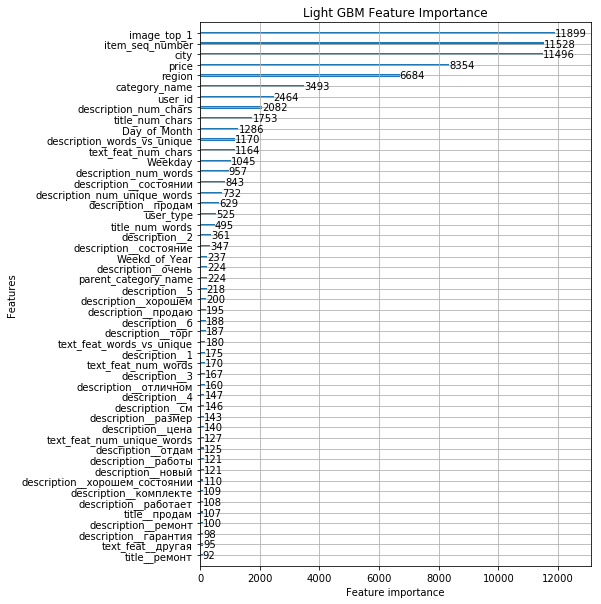

In [25]:
# Go Go Go
modelstart = time.time()
lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=4000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=200,
    verbose_eval=200
)

# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig('feature_import.png')

print("Model Evaluation Stage")
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
lgpred = lgb_clf.predict(testing)
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("lgsub.csv",index=True,header=True)
print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))